In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import scipy
from scipy.optimize import curve_fit
import seaborn as sns
from matplotlib import cm
import csv
import scipy.io as sio
import pandas as pd
from scipy.special import erf
import time
import os
import torch
from scipy.special import k0

# plotting configuration
ratio = 1.7
figure_len, figure_width = 24*ratio, 18*ratio
title_font_size = 12*ratio
font_size_1, font_size_2 = 9*ratio, 9*ratio
legend_size = 18*ratio
line_width, tick_len = ratio, 4*ratio
marker_size = 5*ratio
plot_line_width = 2*ratio
hfont = {'fontname': 'Arial'}
marker_edge_width = 4
pal = sns.color_palette("deep")
sns.set(style='ticks')

In [2]:
def calc_distance(i, j):
    """calculate the distance between two neurons,
        i and j are the indices of two neurons, i and j are from 0 to N*N-1 (31*30),
        x1 and y1 are the coordinate for the first neuron, x1 and y1 are from 0 to 30.
    """
    N = 30
    x1, y1 = divmod(i, N)
    x2, y2 = divmod(j, N)

    xd = np.minimum(np.abs(x1 - x2), N - np.abs(x1 - x2))
    yd = np.minimum(np.abs(y1 - y2), N - np.abs(y1 - y2))
    return np.sqrt(xd**2 + yd**2)

### load the rate field data

In [3]:
def load_rate_field_data():
    # rate field data is used for plotting.
    # rate_field_data_spatially_compact is used for calculating the error and comparing with the analytical error.
    # unique_sorted_distances_degree_total is also used for plotting.
    
    N = 30
    center = int(((N+1)*N)/2) # index of the center
    distances_to_center = np.array([calc_distance(i, center) for i in range(N * N)]) # calculate the distance between every point in the 2D grid and the center
    sorted_distance_indices = np.argsort(distances_to_center) # indices of the sorted distance in the original array
    sorted_distances = distances_to_center[sorted_distance_indices] # the sorted distances
    sorted_distances_degree = sorted_distances*6 # the sorted distances in degree for all 900 neurons
    
    unique_sorted_distances_degree = np.asarray(sorted(set(sorted_distances_degree))) # remove the repetitive ones
    unique_sorted_distances_degree_left = -unique_sorted_distances_degree[::-1]
    unique_sorted_distances_degree_total = list(unique_sorted_distances_degree_left[:-1]) + list(unique_sorted_distances_degree)
    unique_sorted_distances_degree_total = np.asarray(unique_sorted_distances_degree_total) # the distance in degree, used for plotting
    
    l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
    n_stimulus = len(l_stimulus)
    l_celltype = ['E', 'PV', 'SST', 'VIP']

    l_baseline = sio.loadmat("data/baselines.mat")['baseline']
    rate_field_data_spatially_compact = np.zeros((22*9*4*2)) * np.nan # combined version, 22 spatial bins, 9 stimulus size, 4 cell types, 2 conditions
    rate_field_data = np.zeros((4, 18, 239)) * np.nan # 4 cell types, 18 stimulus conditions, number of unique location 120 *2 - 1

    for i in range(2):
        s_cond = 'classical' if i == 0 else 'inverse'

        for j in range(4):
            # activity
            rate_field_total = sio.loadmat('data/rate_field_activity_' + str(l_celltype[j]) + '.mat')['rate_field_activity']
            
            for k in range(n_stimulus):
                rate_field_instance = rate_field_total[9*i + k, :]
                rate_field_instance_left = rate_field_instance[::-1]
                rate_field_instance_intact = list(rate_field_instance_left[:-1]) + list(rate_field_instance)
                rate_field_data[j, i*9+k, :] = np.asarray(rate_field_instance_intact)

                for m in range(22): # 22 bins for different distance range
                    indices = np.where((unique_sorted_distances_degree >= m*6) & (unique_sorted_distances_degree < (m+1)*6))[0] 
                    
                    # first classical, then inverse; first different spatial bins, then different stimulus size, then different cell types
                    rate_field_data_spatially_compact[792*i + j*22*9+ k*22+m] = np.mean(rate_field_instance[indices] - l_baseline[0, j])
                    
    return rate_field_data, rate_field_data_spatially_compact, unique_sorted_distances_degree_total

rate_field_data, rate_field_data_spatially_compact, unique_sorted_distances_degree_total = load_rate_field_data()

### Fig. S3, S8, S13, S14, S15 - plot simulated rate fields for different conditions

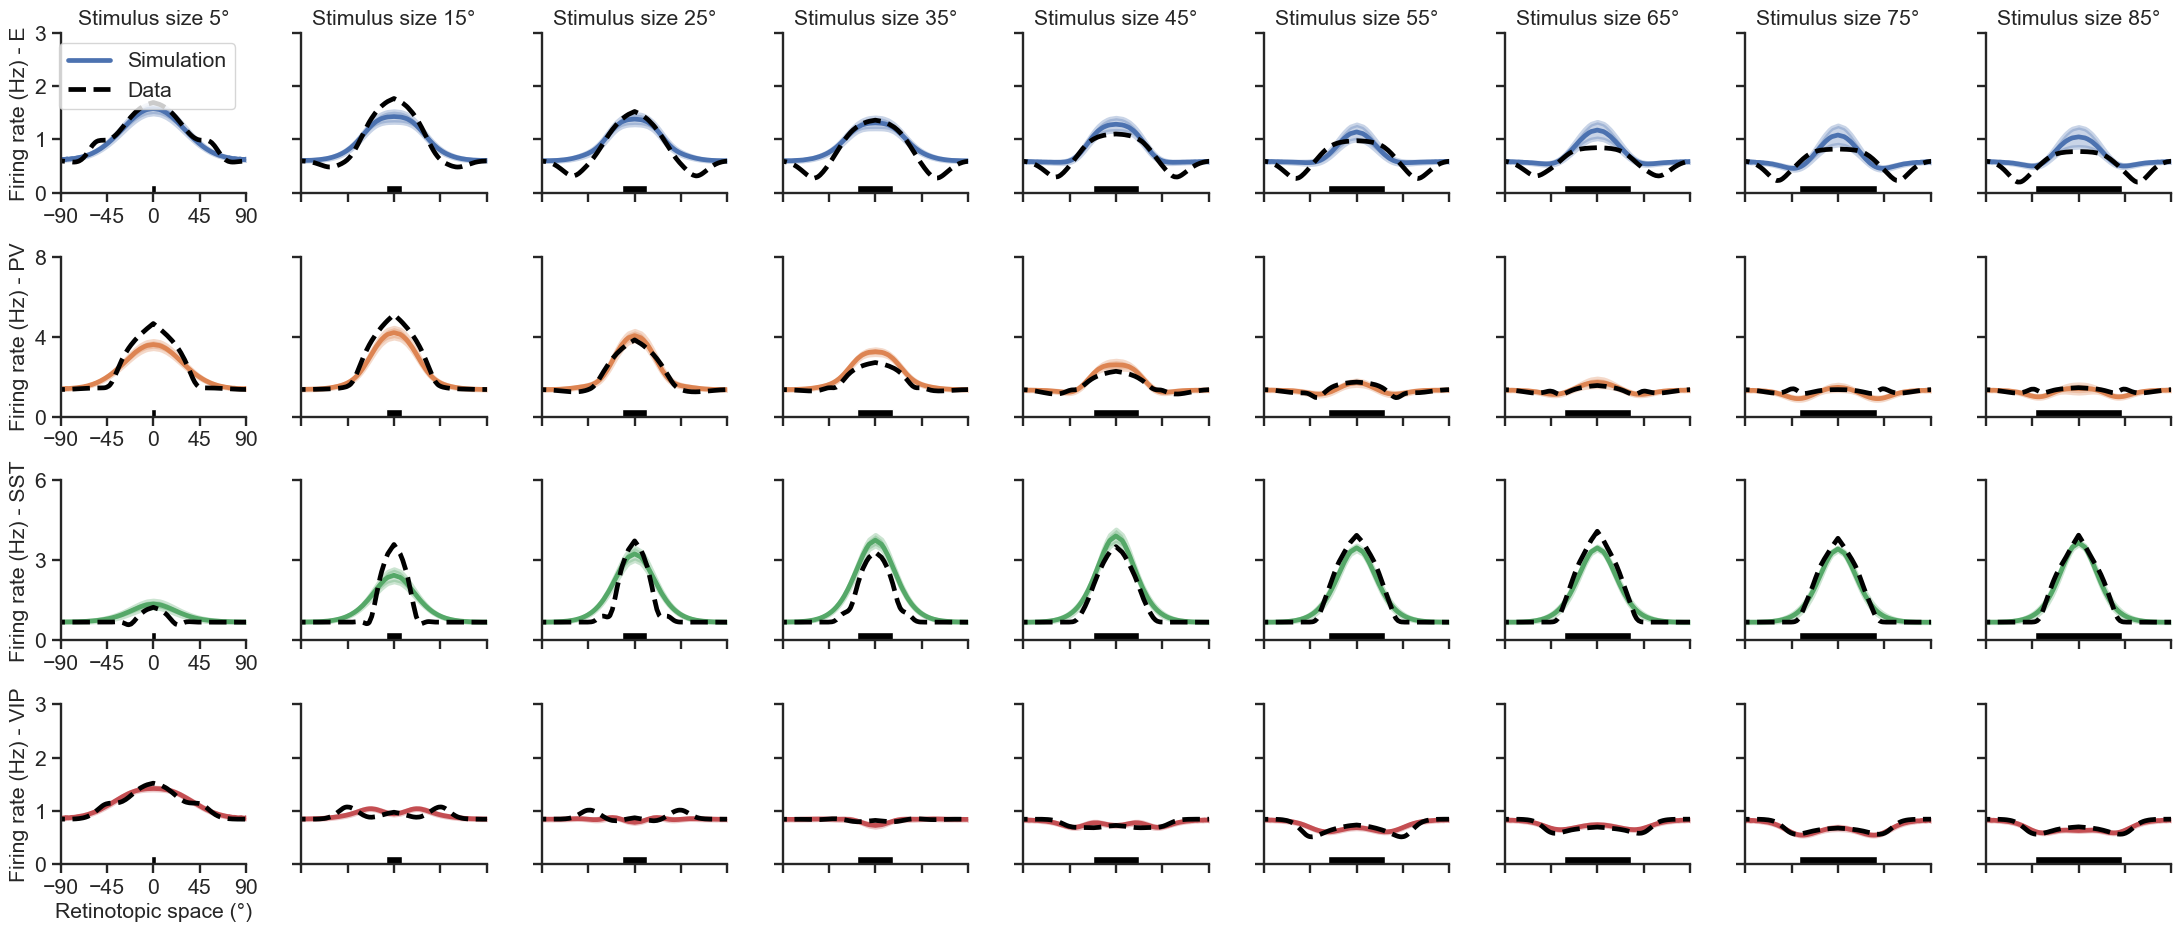

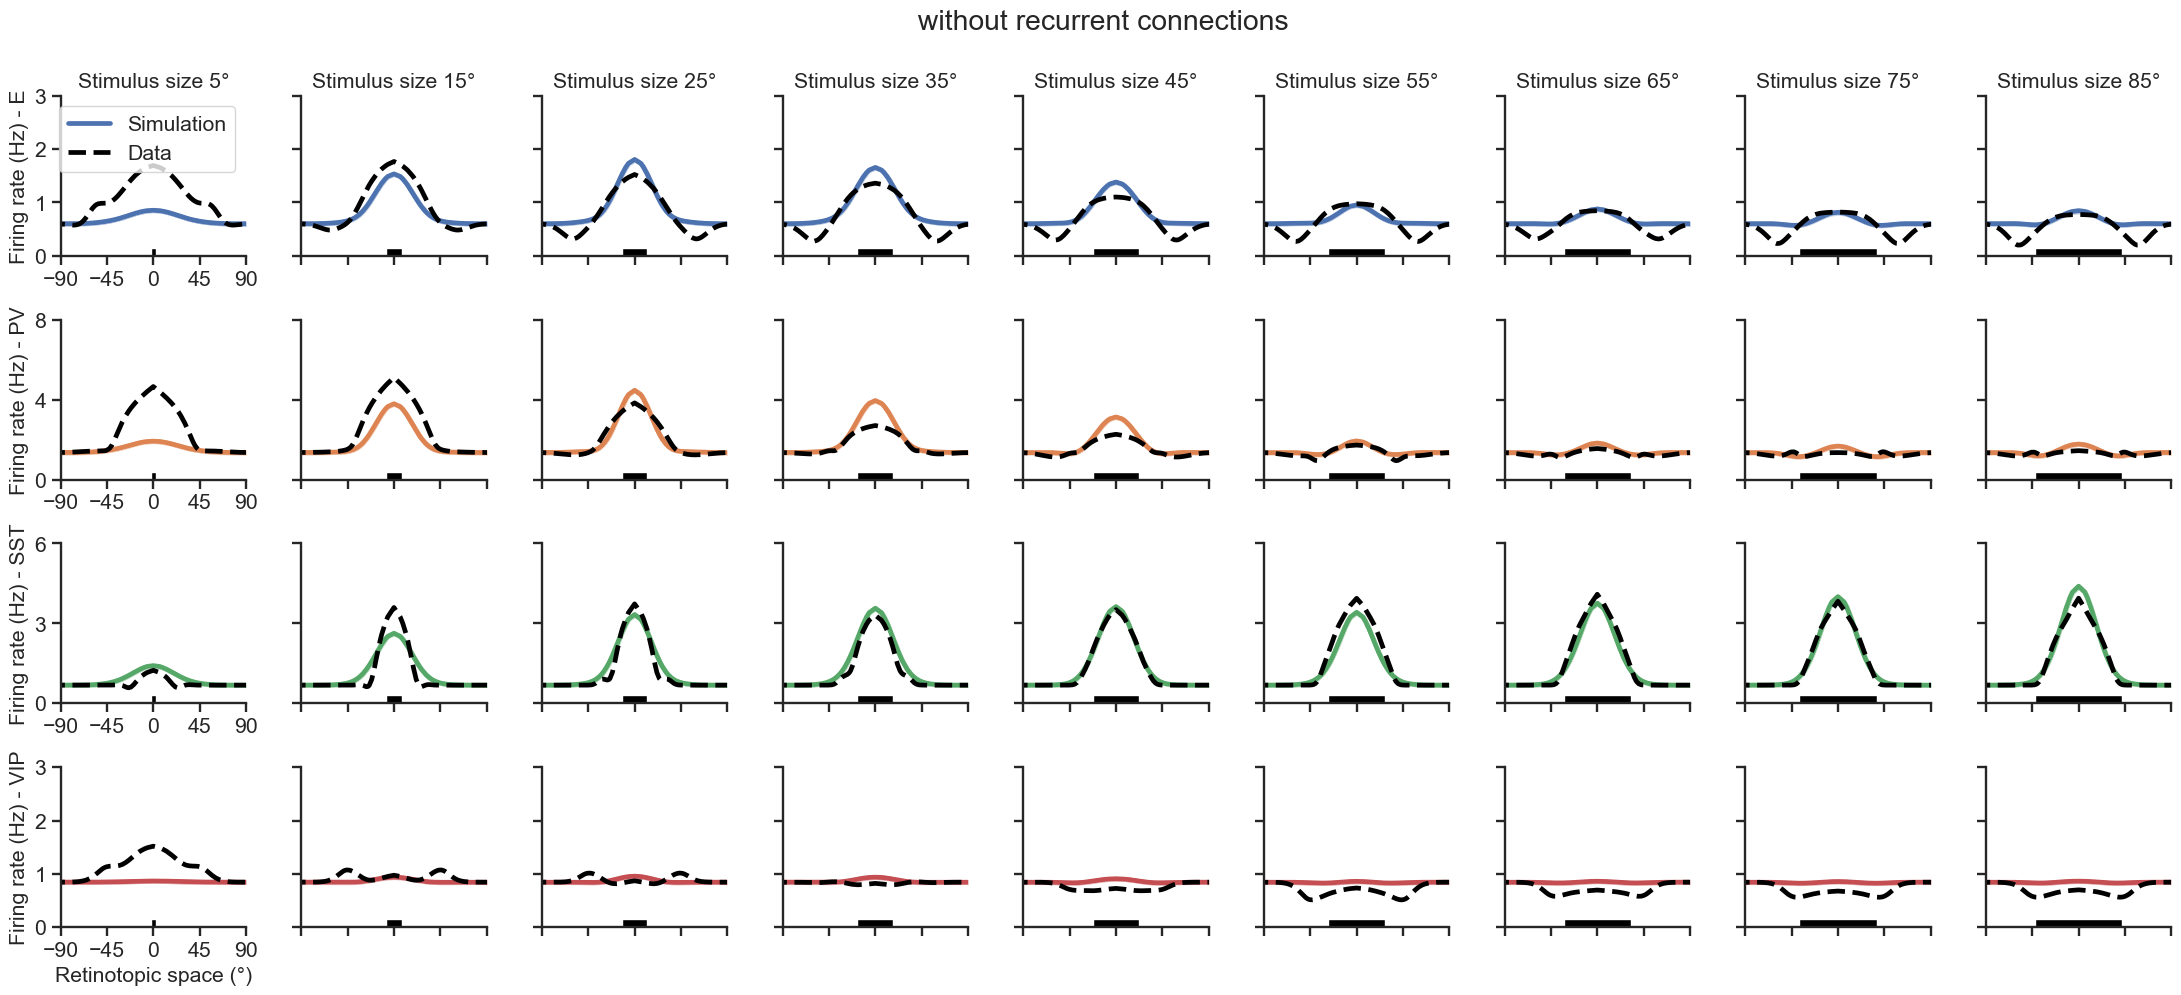

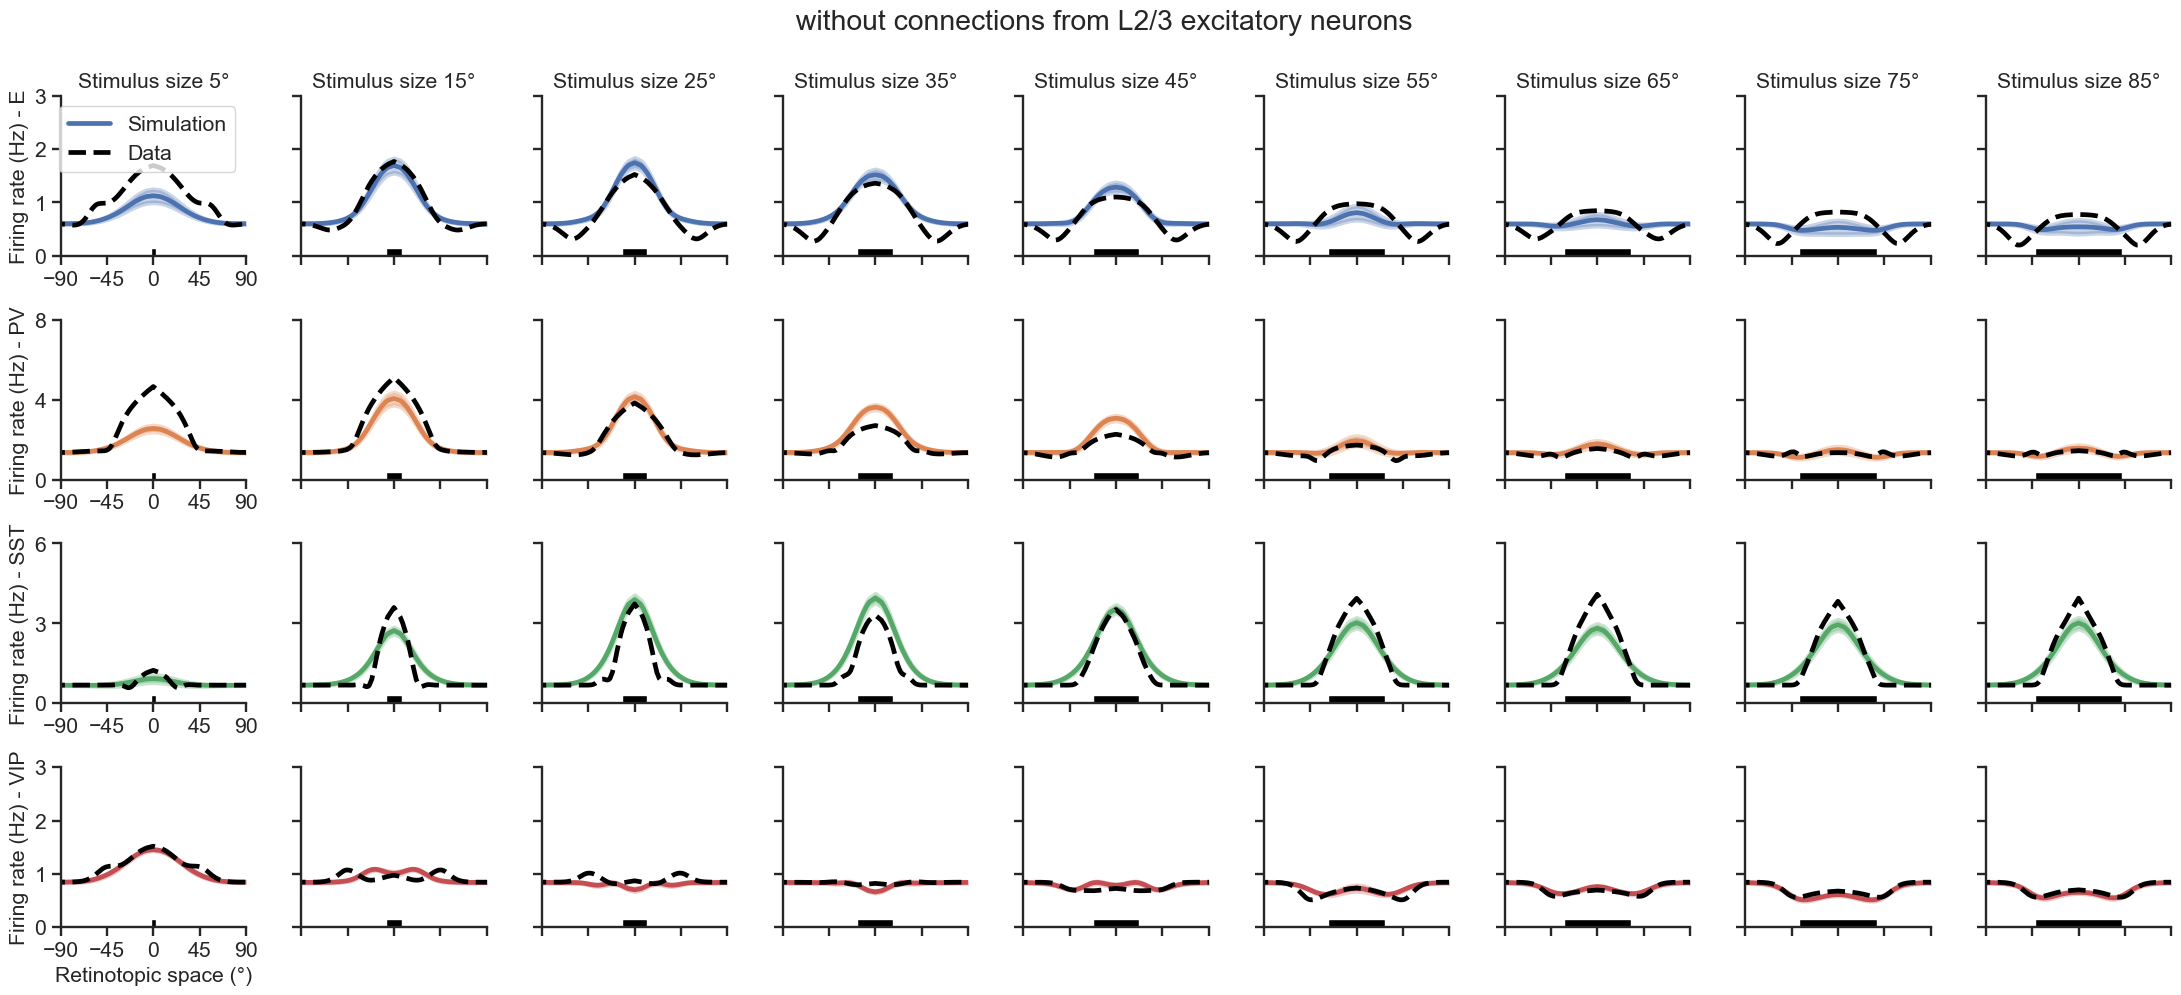

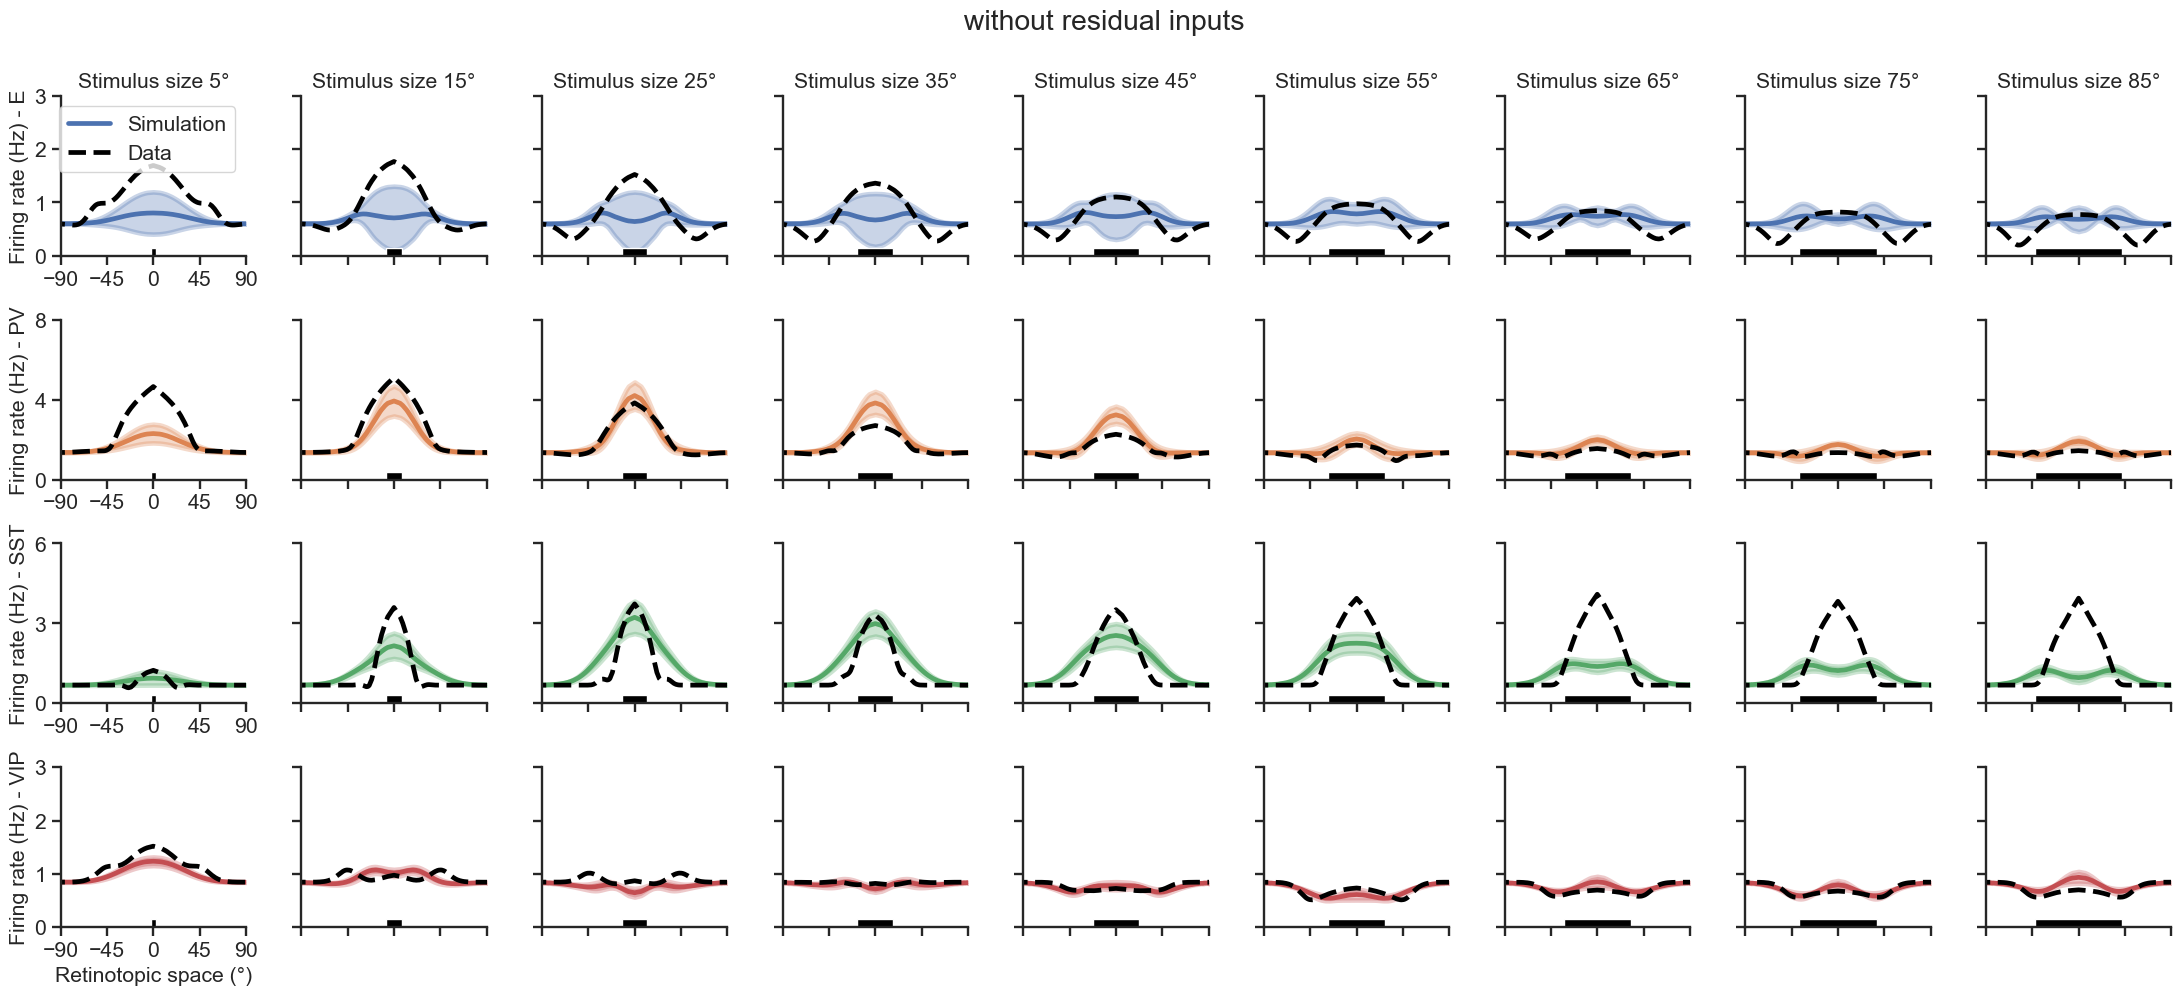

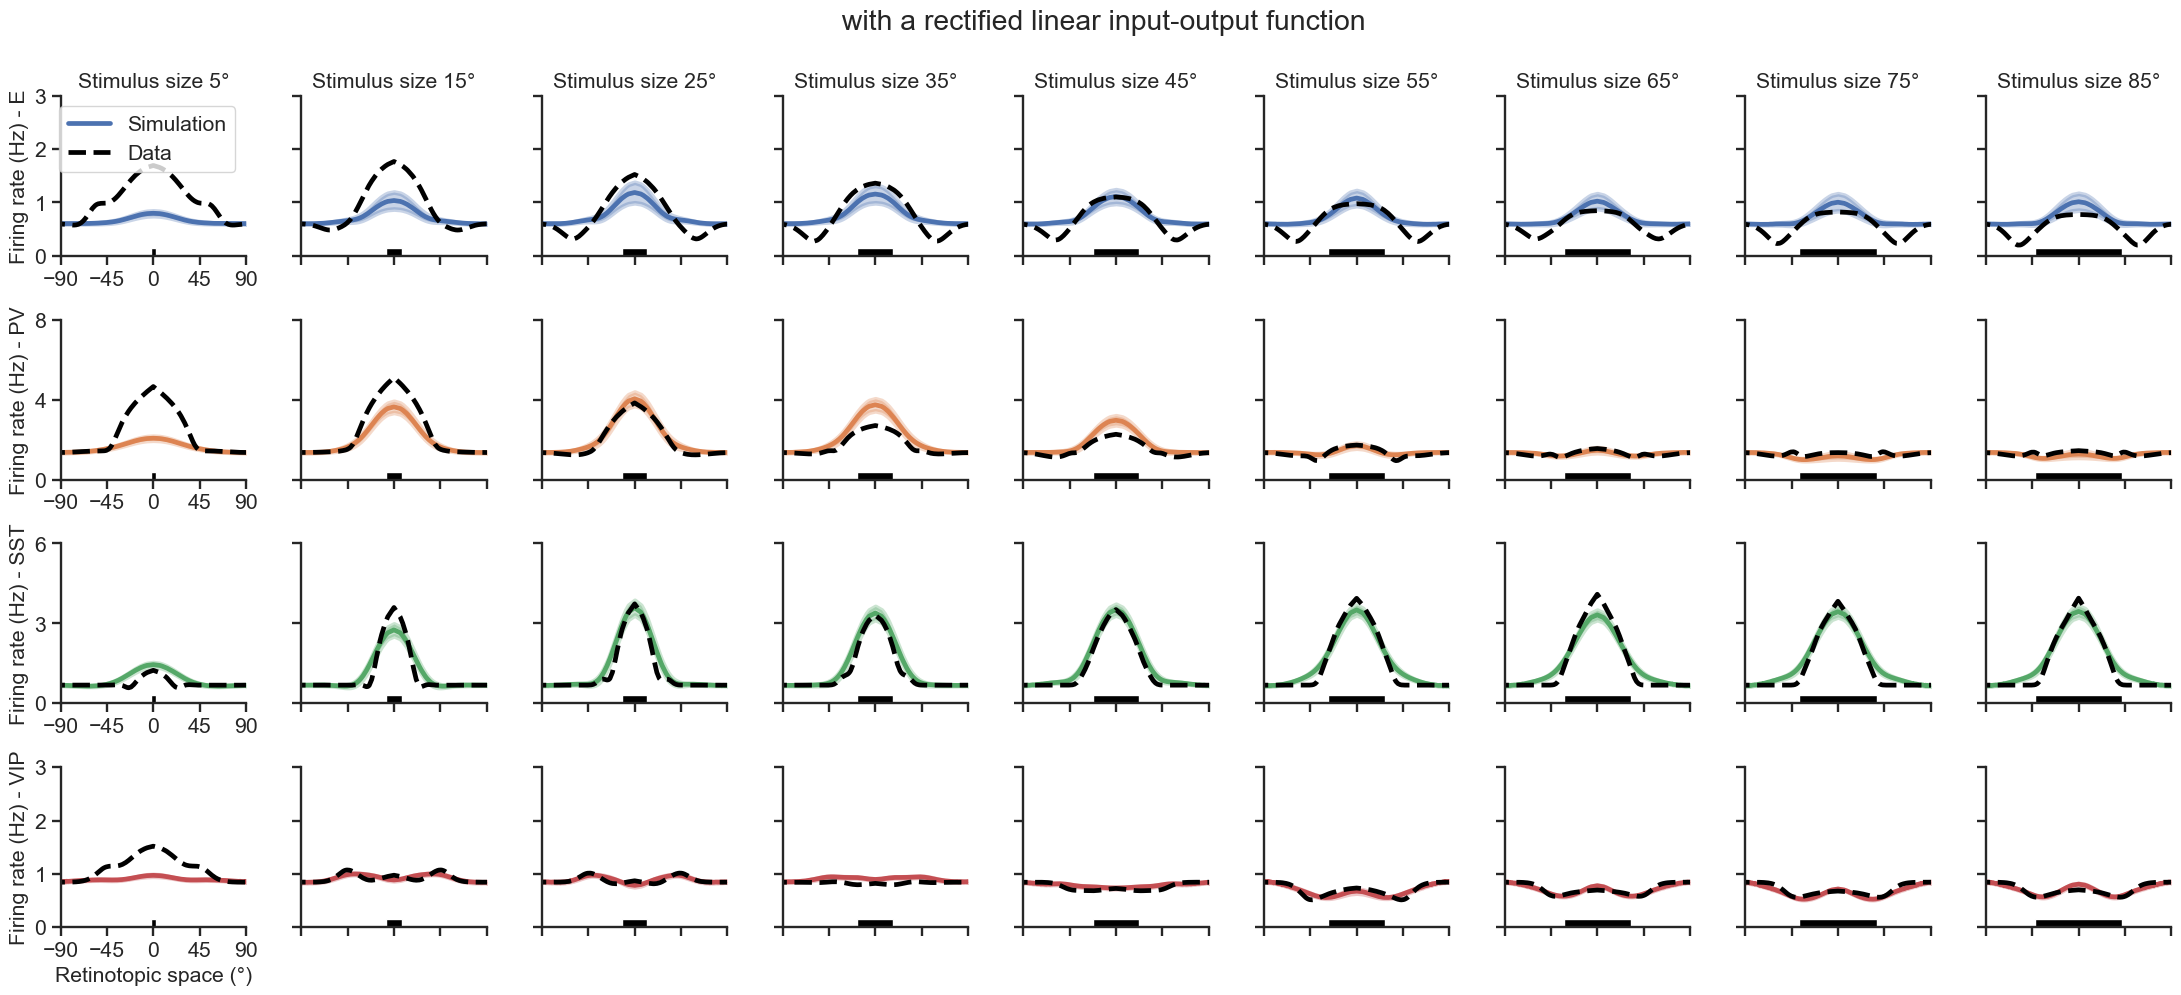

In [4]:
l_config =  ['final_gaussian_classical', 'final_gaussian_classical_without_recurrent_connections', 'final_gaussian_classical_without_recurrent_excitatory_connections', 'final_gaussian_classical_without_residual_inputs', 'final_gaussian_classical_linear_2']
l_title = ['', ' without recurrent connections', ' without connections from L2/3 excitatory neurons', ' without residual inputs', ' with a rectified linear input-output function']

l_celltype = ['E', 'PV', 'SST', 'VIP']
l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

l_y_lowerlims = [0, 0, 0, 0]
l_y_upperlims = [3, 10, 6, 3]

for config_idx in range(len(l_config)):
    config = l_config[config_idx]

    folder_path = 'models/optimized_files_' + config
    model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
    sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
    sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])

    n_selected_models = len(sorted_files)
    
    rate_field_sim_total = np.zeros((239, 4, 9, n_selected_models)) * np.nan

    fig, axes = plt.subplots(4, 9, figsize=(22, 9))
    fig.tight_layout()

    for j in range(4):

        for k in range(9):

            idx1, idx2 = j, k
            axes[idx1, idx2].spines['top'].set_visible(False)
            axes[idx1, idx2].spines['right'].set_visible(False)
            axes[idx1, idx2].spines['bottom'].set_visible(True)
            axes[idx1, idx2].spines['left'].set_visible(True)
            for axis in ['top', 'bottom', 'left', 'right']:
                axes[idx1, idx2].spines[axis].set_linewidth(line_width)
            axes[idx1, idx2].tick_params(width=line_width, length=tick_len)

            for model_name_idx in range(n_selected_models):

                model_name = sorted_files[model_name_idx]

                df = pd.read_csv('simulated_rate_fields/' + config + '_response_grid_' +  str(model_name) + '.csv')

                if j == 0:
                    rate_field_sim_data = df[(df['cell_type'] == 'PYR') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values
                elif j == 1:
                    rate_field_sim_data = df[(df['cell_type'] == 'PV') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values
                elif j == 2:
                    rate_field_sim_data = df[(df['cell_type'] == 'SST') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values
                else:
                    rate_field_sim_data = df[(df['cell_type'] == 'VIP') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values

                rate_field_sim_left = rate_field_sim_data[::-1]
                rate_field_sim = list(rate_field_sim_left[:-1]) + list(rate_field_sim_data)
                rate_field_sim = np.asarray(rate_field_sim) + l_baseline[0, j]

                rate_field_sim_total[:, j, k, model_name_idx] = rate_field_sim

            rate_field_std = np.std(rate_field_sim_total[:, j, k, :], axis=1)
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(rate_field_sim_total[:, j, k, :], axis=1), linewidth=plot_line_width, color=pal[j], zorder=1)
            axes[idx1, idx2].plot(unique_sorted_distances_degree_total, rate_field_data[j, k, :], linewidth=plot_line_width, color='black', linestyle='dashed', zorder=2)
            axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(rate_field_sim_total[:, j, k, :], axis=1) - rate_field_std, np.mean(rate_field_sim_total[:, j, k, :], axis=1) + rate_field_std, linewidth=plot_line_width, color=pal[j], alpha=0.3)

            axes[idx1, idx2].set_xlim(-90, 90)
            axes[idx1, idx2].set_xticks([-90, -45, 0, 45, 90])
            if j == 0:
                axes[idx1, idx2].set_ylim(0, 3)
                axes[idx1, idx2].set_yticks([0, 1, 2, 3])
            elif j == 1:
                axes[idx1, idx2].set_ylim(0, 8)
                axes[idx1, idx2].set_yticks([0, 4, 8])
            elif j == 2:
                axes[idx1, idx2].set_ylim(0, 6)
                axes[idx1, idx2].set_yticks([0, 3, 6])
            else:
                axes[idx1, idx2].set_ylim(0, 3)
                axes[idx1, idx2].set_yticks([0, 1, 2, 3])

            if idx1 == 0:
                axes[idx1, idx2].set_title(f'Stimulus size {l_stimulus[k]}°', fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
            else:
                pass

            axes[idx1, idx2].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size

            if idx1 == 0 and idx2 == 0:
                axes[idx1, idx2].legend(['Simulation', 'Data'], loc='upper right', prop={"family": "Arial", 'size': font_size_1})

            if idx1 ==3 and idx2 == 0:
                axes[idx1, idx2].set_xlabel('Retinotopic space (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

            if idx2 == 0:
                axes[idx1, idx2].set_ylabel('Firing rate (Hz) - ' + l_celltype[j], fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
            else:
                axes[idx1, idx2].set_xticklabels([])
                axes[idx1, idx2].set_yticklabels([])

            y_limits = axes[idx1, idx2].get_ylim()

            rect = matplotlib.patches.Rectangle((-l_stimulus[k]/2, y_limits[0]), l_stimulus[k], (y_limits[1]-y_limits[0])/20, linewidth=1, edgecolor=None, facecolor='black', alpha=1)

            axes[idx1, idx2].add_patch(rect)    

            for label in (axes[idx1, idx2].get_xticklabels() + axes[idx1, idx2].get_yticklabels()):
                label.set_fontname('Arial')

    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    fig.suptitle(l_title[config_idx], y=1.07, fontsize=title_font_size, fontname='Arial')

### Fig. 2 - simulated rate fileds and size-tuning curves of the top ten models

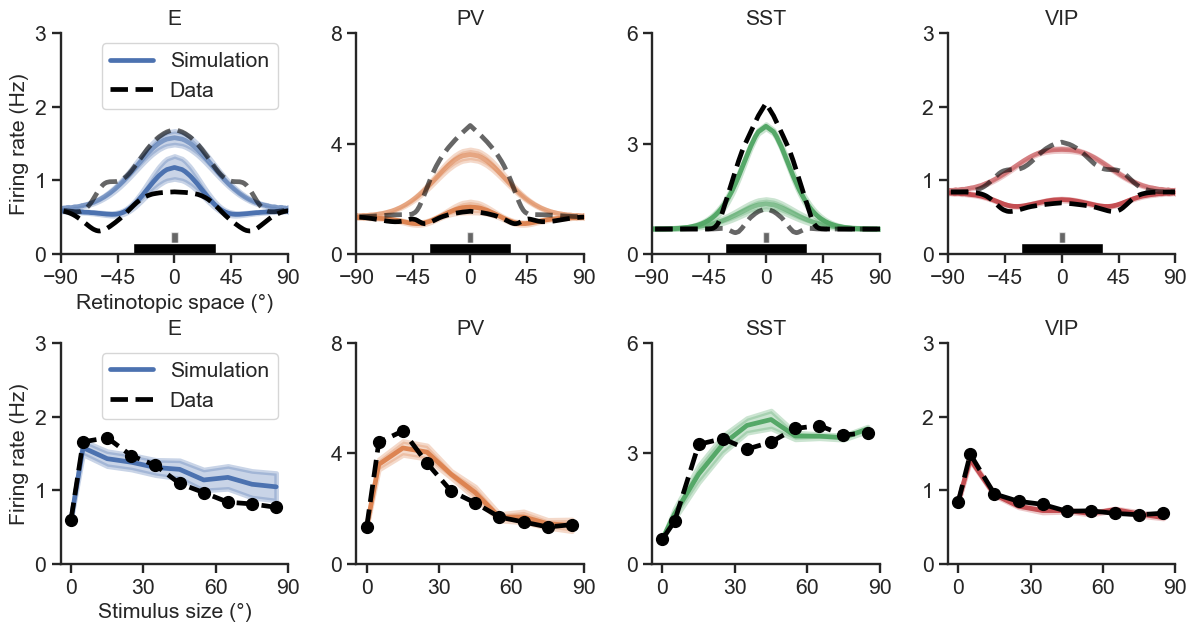

In [5]:
l_config =  ['final_gaussian_classical']
l_title = [' gaussian classical']

rate_field_data, rate_field_data_spatially_compact, unique_sorted_distances_degree_total = load_rate_field_data()

l_celltype = ['E', 'PV', 'SST', 'VIP']
l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

l_y_lowerlims = [0, 0, 0, 0]
l_y_upperlims = [3, 10, 6, 3]
stim_idx_1, stim_idx_2 = 0, 6

size_tuning_data_classical = np.zeros((4, 10)) * np.nan
size_tuning_data_classical[:, 0] = l_baseline[0, :4]
size_tuning_data_classical[:, 1:] = rate_field_data[:, :9, 120]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.tight_layout()
        
for ii in range(2):
    
    if ii == 0:
        for config_idx in range(len(l_config)):
            config = l_config[config_idx]

            folder_path = 'models/optimized_files_' + config
            model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
            sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
            sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])

            n_selected_models = 10

            l_model_name_idx = np.arange(n_selected_models)
            l_rate_fields_examples = np.ones((2, n_selected_models, 4, 239)) * np.nan

            for j in range(4):

                for k in range(9):

                    for model_name_idx in l_model_name_idx:

                        model_name = sorted_files[model_name_idx]

                        df = pd.read_csv('simulated_rate_fields/' + config + '_response_grid_' +  str(model_name) + '.csv')

                        if j == 0:
                            rate_field_sim_data = df[(df['cell_type'] == 'PYR') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values
                        elif j == 1:
                            rate_field_sim_data = df[(df['cell_type'] == 'PV') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values
                        elif j == 2:
                            rate_field_sim_data = df[(df['cell_type'] == 'SST') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values
                        else:
                            rate_field_sim_data = df[(df['cell_type'] == 'VIP') & (df['size'] == l_stimulus[k]) & (df['inverse'] == False)]['dr'].values

                        rate_field_sim_left = rate_field_sim_data[::-1]
                        rate_field_sim = list(rate_field_sim_left[:-1]) + list(rate_field_sim_data)
                        rate_field_sim = np.asarray(rate_field_sim) + l_baseline[0, j]

                        if k == stim_idx_1:
                            l_rate_fields_examples[0, model_name_idx, j, :] = rate_field_sim

                        if k == stim_idx_2:
                            l_rate_fields_examples[1, model_name_idx, j, :] = rate_field_sim


            for m in range(4):
                idx1, idx2 = ii, m
                axes[idx1, idx2].spines['top'].set_visible(False)
                axes[idx1, idx2].spines['right'].set_visible(False)
                axes[idx1, idx2].spines['bottom'].set_visible(True)
                axes[idx1, idx2].spines['left'].set_visible(True)
                for axis in ['top', 'bottom', 'left', 'right']:
                    axes[idx1, idx2].spines[axis].set_linewidth(line_width)
                axes[idx1, idx2].tick_params(width=line_width, length=tick_len)

                rf_std_1 = np.std(l_rate_fields_examples[0, :, m, :], axis=0)
                rf_std_2 = np.std(l_rate_fields_examples[1, :, m, :], axis=0)

                axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(l_rate_fields_examples[1, :, m, :], axis=0), linewidth=plot_line_width, color=pal[m], alpha=1, zorder=1)
                axes[idx1, idx2].plot(unique_sorted_distances_degree_total, rate_field_data[m, stim_idx_2, :], linewidth=plot_line_width, color='black', linestyle='dashed', alpha=1, zorder=2)

                axes[idx1, idx2].plot(unique_sorted_distances_degree_total, np.mean(l_rate_fields_examples[0, :, m, :], axis=0), linewidth=plot_line_width, color=pal[m], alpha=0.6, zorder=1)
                axes[idx1, idx2].plot(unique_sorted_distances_degree_total, rate_field_data[m, stim_idx_1, :], linewidth=plot_line_width, color='black', linestyle='dashed', alpha=0.6, zorder=2)

                axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(l_rate_fields_examples[0, :, m, :], axis=0) - rf_std_1, np.mean(l_rate_fields_examples[0, :, m, :], axis=0) + rf_std_1, linewidth=plot_line_width, color=pal[m], alpha=0.3)
                axes[idx1, idx2].fill_between(unique_sorted_distances_degree_total, np.mean(l_rate_fields_examples[1, :, m, :], axis=0) - rf_std_2, np.mean(l_rate_fields_examples[1, :, m, :], axis=0) + rf_std_2, linewidth=plot_line_width, color=pal[m], alpha=0.3)

                axes[idx1, idx2].set_xlim(-90, 90)
                axes[idx1, idx2].set_xticks([-90, -45, 0, 45, 90])
                if m == 0:
                    axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                    axes[idx1, idx2].set_ylim(0, 3)
                elif m == 1:
                    axes[idx1, idx2].set_yticks([0, 4, 8])
                    axes[idx1, idx2].set_ylim(0, 8)
                elif m == 2:
                    axes[idx1, idx2].set_ylim(0, 6)
                    axes[idx1, idx2].set_yticks([0, 3, 6])
                else:
                    axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                    axes[idx1, idx2].set_ylim(0, 3)

                axes[idx1, idx2].set_title(l_celltype[m], fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})

                axes[idx1, idx2].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size

                if idx1 == 0 and idx2==0:
                    axes[idx1, idx2].legend(['Simulation', 'Data'], loc='upper right', prop={"family": "Arial", 'size': font_size_1})

                if idx1 == 0 and idx2 ==0:
                    axes[idx1, idx2].set_xlabel('Retinotopic space (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
                    axes[idx1, idx2].set_ylabel('Firing rate (Hz)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

                y_limits = axes[idx1, idx2].get_ylim()

                rect1 = matplotlib.patches.Rectangle((-l_stimulus[stim_idx_1]/2, y_limits[0]+(y_limits[1]-y_limits[0])/20), l_stimulus[stim_idx_1], (y_limits[1]-y_limits[0])/20, facecolor='black', alpha=0.6)
                rect2 = matplotlib.patches.Rectangle((-l_stimulus[stim_idx_2]/2, y_limits[0]), l_stimulus[stim_idx_2], (y_limits[1]-y_limits[0])/20, facecolor='black', alpha=1)

                axes[idx1, idx2].add_patch(rect1)
                axes[idx1, idx2].add_patch(rect2)

                for label in (axes[idx1, idx2].get_xticklabels() + axes[idx1, idx2].get_yticklabels()):
                    label.set_fontname('Arial')

    else:

        l_stimulus_plot = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]
        l_stim_type = [0]

        for config_idx in range(len(l_config)):
            config = l_config[config_idx]

            folder_path = 'models/optimized_files_' + config
            model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
            sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
            sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])
            n_selected_models = len(sorted_files)

            size_tuning_data_classical_sim = np.zeros((n_selected_models, 4, 10)) * np.nan
            size_tuning_data_classical_sim[:, 0, 0] = l_baseline[0, 0]
            size_tuning_data_classical_sim[:, 1, 0] = l_baseline[0, 1]
            size_tuning_data_classical_sim[:, 2, 0] = l_baseline[0, 2]
            size_tuning_data_classical_sim[:, 3, 0] = l_baseline[0, 3]

            for model_name_idx in range(n_selected_models):
                model_name = sorted_files[model_name_idx]

                df = pd.read_csv('simulated_rate_fields/' + config + '_response_grid_' +  str(model_name) + '.csv')

                for i in l_stim_type:

                    for j in range(4):

                        for k in range(n_stimulus):

                            if j == 0:
                                rate_field_sim_data = df[(df['cell_type'] == 'PYR') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                            elif j == 1:
                                rate_field_sim_data = df[(df['cell_type'] == 'PV') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                            elif j == 2:
                                rate_field_sim_data = df[(df['cell_type'] == 'SST') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                            else:
                                rate_field_sim_data = df[(df['cell_type'] == 'VIP') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values

                            size_tuning_data_classical_sim[model_name_idx, j, k+1] = rate_field_sim_data[0] + l_baseline[0, j]

            for l in range(1):
                for j in range(4):
                    idx1, idx2 = ii, j

                    axes[idx1, idx2].spines['top'].set_visible(False)
                    axes[idx1, idx2].spines['right'].set_visible(False)
                    axes[idx1, idx2].spines['bottom'].set_visible(True)
                    axes[idx1, idx2].spines['left'].set_visible(True)
                    for axis in ['top', 'bottom', 'left', 'right']:
                        axes[idx1, idx2].spines[axis].set_linewidth(line_width)
                    axes[idx1, idx2].tick_params(width=line_width, length=tick_len)

                    size_tuning_std = np.std(size_tuning_data_classical_sim[:, j, :], axis=0)
                    if config == 'final_gaussian_classical_without_recurrent_connections':
                        axes[idx1, idx2].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linestyle='dashed', linewidth=plot_line_width, zorder=1)
                    elif config == 'final_gaussian_classical_without_recurrent_excitatory_connections':
                        axes[idx1, idx2].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linestyle='dotted', linewidth=plot_line_width, zorder=1)
                    else:
                        axes[idx1, idx2].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linewidth=plot_line_width, zorder=1)

                    axes[idx1, idx2].plot(l_stimulus_plot, size_tuning_data_classical[j, :], color='black', linestyle='dashed', linewidth=plot_line_width, zorder=2)
                    axes[idx1, idx2].fill_between(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0) - size_tuning_std, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0) + size_tuning_std, linewidth=plot_line_width, color=pal[j], alpha=0.3)
                    for n in range(10):
                        axes[idx1, idx2].plot(l_stimulus_plot[n], size_tuning_data_classical[j, n], marker='o', color='black', markersize=marker_size, zorder=2)

                    axes[idx1, idx2].set_title(l_celltype[j], fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
                    axes[idx1, idx2].set_xticks([0, 30, 60, 90])

                    if j == 0:
                        axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                        axes[idx1, idx2].set_ylim(0, 3)
                    elif j == 1:
                        axes[idx1, idx2].set_yticks([0, 4, 8])
                        axes[idx1, idx2].set_ylim(0, 8)
                    elif j == 2:
                        axes[idx1, idx2].set_yticks([0, 3, 6])
                        axes[idx1, idx2].set_ylim(0, 6)
                    else:
                        axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                        axes[idx1, idx2].set_ylim(0, 3)

                    if idx1 == 1 and idx2 == 0:
                        axes[idx1, idx2].legend(['Simulation', 'Data'], loc='upper right', prop={"family": "Arial", 'size': font_size_1})
                        axes[idx1, idx2].set_xlabel(f'Stimulus size (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
                        axes[idx1, idx2].set_ylabel('Firing rate (Hz)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

                    axes[idx1, idx2].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size
                    for label in (axes[idx1, idx2].get_xticklabels() + axes[idx1, idx2].get_yticklabels()):
                        label.set_fontname('Arial')

fig.subplots_adjust(hspace=0.4, wspace=0.3)
# fig.savefig('paper_figures/paper_pdf/Fig_simulated_rate_fields_size_tuning_curves.pdf', bbox_inches='tight')

### Fig. S4 - optimized network parameters for the top ten models

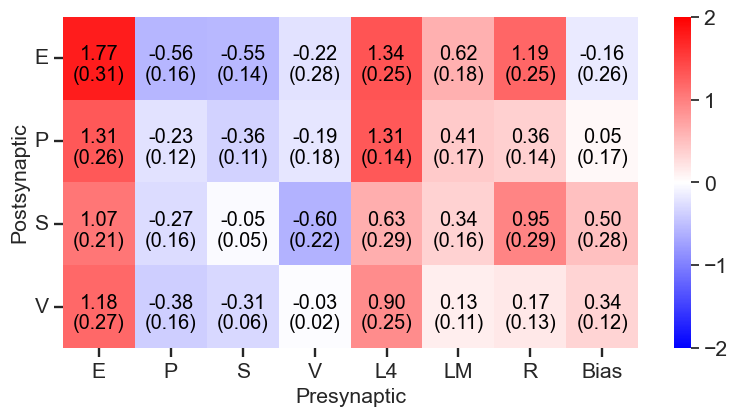

In [6]:
for config_idx in range(len(l_config)):
    config = l_config[config_idx]
    
    l_n_parameters = np.ones(len(l_config)) * 8
    n_parameters = l_n_parameters[config_idx]

    folder_path = 'models/optimized_files_' + config
    model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
    sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
    sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files]) 

    n_selected_models = 10

    para_mat = np.zeros((4, int(n_parameters), n_selected_models)) * np.nan
    para_E, para_PV, para_SST, para_VIP = np.zeros((int(n_parameters), n_selected_models)) * np.nan, np.zeros((int(n_parameters), n_selected_models)) * np.nan, np.zeros((int(n_parameters), n_selected_models)) * np.nan, np.zeros((int(n_parameters), n_selected_models)) * np.nan

    bias_mat = sio.loadmat('data/bias_mat_' + config + '.mat')['bias_mat']
    
    for i in range(n_selected_models):
        
        model_name = sorted_files[i]

        conn_file_path = folder_path + '/' + model_name
        data = torch.load(conn_file_path, map_location=torch.device('cpu'))
        optimized_network_tensor = data['gW']
        optimized_network = optimized_network_tensor.detach().cpu().numpy()
        opti_conn_mat = optimized_network[:4, :]
        bs = np.array([0.5996, 1.35, 0.6818, 0.8437, 0.6092, 0.5996])
        
        # convert the weights
        opti_conn_mat[0, :] = opti_conn_mat[0, :]/(2 * np.sqrt(bs[0]))
        opti_conn_mat[1, :] = opti_conn_mat[1, :]/(2 * np.sqrt(bs[1]))
        opti_conn_mat[2, :] = opti_conn_mat[2, :]/(2 * np.sqrt(bs[2]))
        opti_conn_mat[3, :] = opti_conn_mat[3, :]/(2 * np.sqrt(bs[3]))

        para_E[:7, i] = opti_conn_mat[0, :7]
        para_PV[:7, i] = opti_conn_mat[1, :7]
        para_SST[:7, i] = opti_conn_mat[2, :7]
        para_VIP[:7, i] = opti_conn_mat[3, :7]
        
        para_E[1:4, i] = -para_E[1:4, i]
        para_PV[1:4, i] = -para_PV[1:4, i]
        para_SST[1:4, i] = -para_SST[1:4, i]
        para_VIP[1:4, i] = -para_VIP[1:4, i]

        para_E[-1, i] = bias_mat[0, i]
        para_PV[-1, i] = bias_mat[1, i]
        para_SST[-1, i] = bias_mat[2, i]
        para_VIP[-1, i] = bias_mat[3, i]
        
        para_mat[0, :, i] = para_E[:, i]
        para_mat[1, :, i] = para_PV[:, i]
        para_mat[2, :, i] = para_SST[:, i]
        para_mat[3, :, i] = para_VIP[:, i]
        
    para_mat_mean = np.mean(para_mat, axis=2)
    para_mat_std = np.std(para_mat, axis=2)

    fig, axes = plt.subplots(1, 1, figsize=(8, 4))
    fig.tight_layout()

    axes.spines['top'].set_visible(False)
    axes.spines['right'].set_visible(False)
    axes.spines['bottom'].set_visible(True)
    axes.spines['left'].set_visible(True)
    for axis in ['top', 'bottom', 'left', 'right']:
        axes.spines[axis].set_linewidth(line_width)
    axes.tick_params(width=line_width, length=tick_len)
    
    g = sns.heatmap(para_mat_mean, cmap="bwr", vmin=-2, vmax=2)
    g.set_facecolor('gray')
    g.collections[0].colorbar.set_label("")
    g.figure.axes[-1].yaxis.label.set_size(font_size_1)
    
    axes.set_xticks(np.asarray([0, 1, 2, 3, 4, 5, 6, 7]) + 0.5, ['E', 'P', 'S', 'V', 'L4', 'LM', 'R', 'Bias'])
    axes.set_yticks(np.asarray([0, 1, 2, 3]) + 0.5, ['E', 'P', 'S', 'V'])
    axes.set_xlabel('Presynaptic', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
    axes.set_ylabel('Postsynaptic', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
    
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=font_size_1)
    cbar = axes.collections[0].colorbar
    cbar.set_ticks([-2, -1, 0, 1, 2])
    
    axes.tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size
    for label in (axes.get_xticklabels() + axes.get_yticklabels()):
        label.set_fontname('Arial')
        
    for i in range(para_mat_mean.shape[0]):
        for j in range(para_mat_mean.shape[1]):
            mean_val = para_mat_mean[i, j]
            std_val = para_mat_std[i, j]

            # First line: mean
            axes.text(
                j + 0.5, i + 0.45,
                f"{mean_val:.2f}",
                ha='center', va='center',
                color='black',
                fontsize=font_size_1 - 1,
                fontname='Arial'
            )

            # Second line: std
            axes.text(
                j + 0.5, i + 0.70,   # slightly lower relative to the mean
                f"({std_val:.2f})",
                ha='center', va='center',
                color='black',
                fontsize=font_size_1 - 1,
                fontname='Arial'
            )
    
#     title_font_size = 16
#     fig.suptitle('Optimized network parameters', y=1.05, fontsize=title_font_size, fontname='Arial')
    # fig.savefig('paper_figures/paper_pdf/Fig_optimized_network_parameters.pdf', bbox_inches='tight')

### Fig. 5 - size-tuning curves of the top ten models obtained by optimization without recurrent connections, without connections from L2/3 excitatory connections, with a rectified linear input-output function 

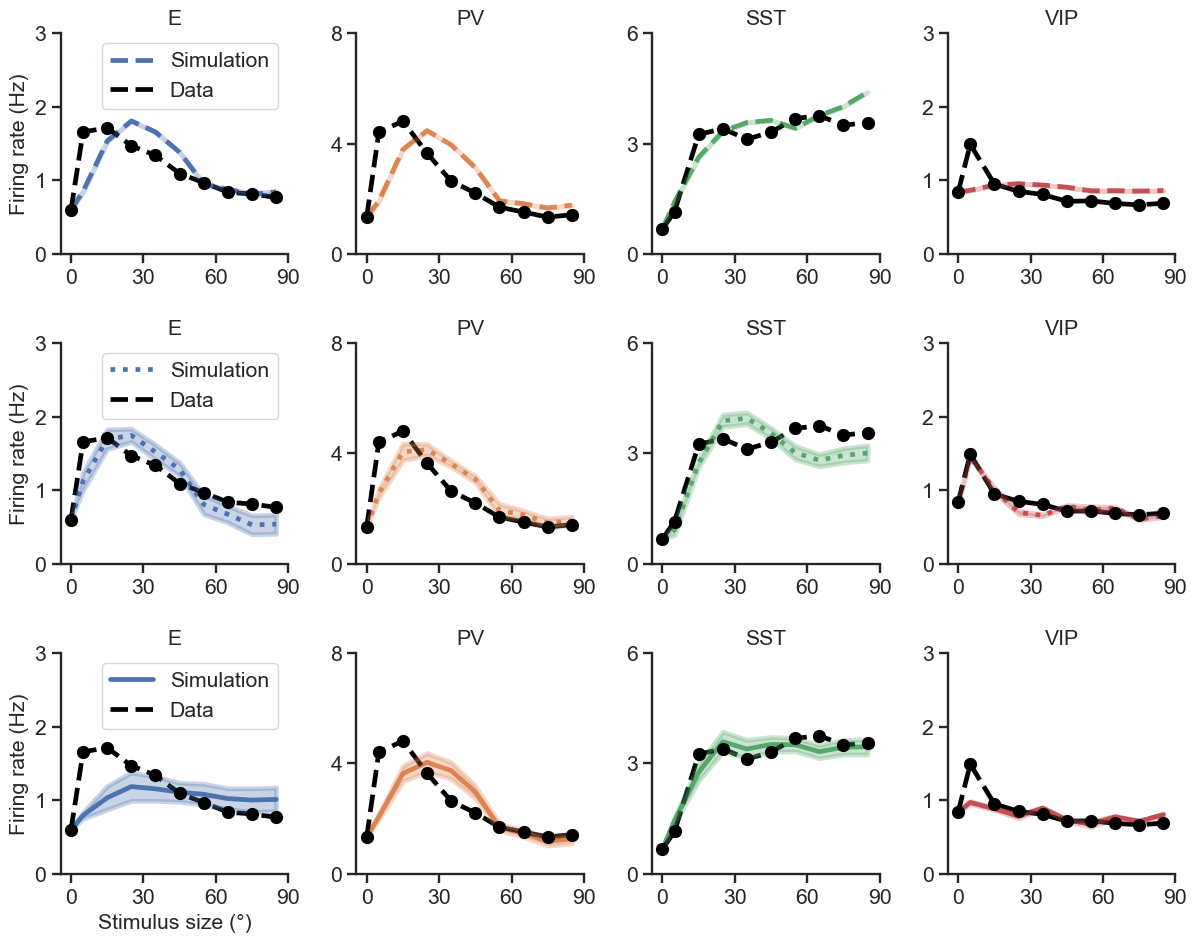

In [7]:
l_config =  ['final_gaussian_classical_without_recurrent_connections', 'final_gaussian_classical_without_recurrent_excitatory_connections', 'final_gaussian_classical_linear_2']
l_title = [' without recurrent connections', ' without connections from L2/3 excitatory neurons', ' with a rectified linear input-output function']

l_celltype = ['E', 'PV', 'SST', 'VIP']
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

size_tuning_data_classical = np.zeros((4, 10)) * np.nan
size_tuning_data_inverse = np.zeros((4, 9)) * np.nan
size_tuning_data_classical[:, 0] = l_baseline[0, :4]
size_tuning_data_classical[:, 1:] = rate_field_data[:, :9, 120]
size_tuning_data_inverse[:, :] = rate_field_data[:, 9:, 120]
l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)

l_stimulus_plot = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]

fig, axes = plt.subplots(3, 4, figsize=(12, 9.1))
fig.tight_layout()

for config_idx in range(len(l_config)):
    config = l_config[config_idx]

    folder_path = 'models/optimized_files_' + config
    model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
    sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
    sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])
    if len(sorted_numbers) > 10:
        n_selected_models = 10
    else:
        n_selected_models = len(sorted_numbers)

    size_tuning_data_classical_sim = np.zeros((n_selected_models, 4, 10)) * np.nan
    size_tuning_data_inverse_sim = np.zeros((n_selected_models, 4, 9)) * np.nan
    size_tuning_data_classical_sim[:, 0, 0] = l_baseline[0, 0]
    size_tuning_data_classical_sim[:, 1, 0] = l_baseline[0, 1]
    size_tuning_data_classical_sim[:, 2, 0] = l_baseline[0, 2]
    size_tuning_data_classical_sim[:, 3, 0] = l_baseline[0, 3]

    for model_name_idx in range(n_selected_models):
        model_name = sorted_files[model_name_idx]

        df = pd.read_csv('simulated_rate_fields/' + config + '_response_grid_' +  str(model_name) + '.csv')

        for i in l_stim_type:

            for j in range(4):

                for k in range(n_stimulus):

                    if j == 0:
                        rate_field_sim_data = df[(df['cell_type'] == 'PYR') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                    elif j == 1:
                        rate_field_sim_data = df[(df['cell_type'] == 'PV') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                    elif j == 2:
                        rate_field_sim_data = df[(df['cell_type'] == 'SST') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                    else:
                        rate_field_sim_data = df[(df['cell_type'] == 'VIP') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values

                    if i == 0:
                        size_tuning_data_classical_sim[model_name_idx, j, k+1] = rate_field_sim_data[0] + l_baseline[0, j]
                    else:
                        size_tuning_data_inverse_sim[model_name_idx, j, k] = rate_field_sim_data[0] + l_baseline[0, j]

    for l in range(1):

        for j in range(4):
            idx1, idx2 = config_idx, j

            axes[idx1, idx2].spines['top'].set_visible(False)
            axes[idx1, idx2].spines['right'].set_visible(False)
            axes[idx1, idx2].spines['bottom'].set_visible(True)
            axes[idx1, idx2].spines['left'].set_visible(True)
            for axis in ['top', 'bottom', 'left', 'right']:
                axes[idx1, idx2].spines[axis].set_linewidth(line_width)
            axes[idx1, idx2].tick_params(width=line_width, length=tick_len)

            size_tuning_std = np.std(size_tuning_data_classical_sim[:, j, :], axis=0)
            if config_idx == 0:
                axes[idx1, idx2].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linewidth=plot_line_width, linestyle='dashed', zorder=1)
            elif config_idx == 1:
                axes[idx1, idx2].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linewidth=plot_line_width, linestyle='dotted', zorder=1)
            else:
                axes[idx1, idx2].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linewidth=plot_line_width, zorder=1)

            axes[idx1, idx2].plot(l_stimulus_plot, size_tuning_data_classical[j, :], color='black', linestyle='dashed', linewidth=plot_line_width, zorder=1)
            axes[idx1, idx2].fill_between(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0) - size_tuning_std, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0) + size_tuning_std, linewidth=plot_line_width, color=pal[j], alpha=0.3)
            for n in range(10):
                axes[idx1, idx2].plot(l_stimulus_plot[n], size_tuning_data_classical[j, n], marker='o', color='black', markersize=marker_size, zorder=2)
            
            axes[idx1, idx2].set_title(l_celltype[j], fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
            axes[idx1, idx2].set_xticks([0, 30, 60, 90])

            if j == 0:
                axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                axes[idx1, idx2].set_ylim(0, 3)
            elif j == 1:
                axes[idx1, idx2].set_yticks([0, 4, 8])
                axes[idx1, idx2].set_ylim(0, 8)
            elif j == 2:
                axes[idx1, idx2].set_yticks([0, 3, 6])
                axes[idx1, idx2].set_ylim(0, 6)
            else:
                axes[idx1, idx2].set_yticks([0, 1, 2, 3])
                axes[idx1, idx2].set_ylim(0, 3)

            if idx2 ==0:
                axes[idx1, idx2].legend(['Simulation', 'Data'], loc='upper right', prop={"family": "Arial", 'size': font_size_1})
            
            if idx2 == 0:
                axes[idx1, idx2].set_ylabel('Firing rate (Hz)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
            
            if idx1 == 2 and idx2 ==0:
                axes[idx1, idx2].set_xlabel(f'Stimulus size (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
                
            axes[idx1, idx2].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size
            for label in (axes[idx1, idx2].get_xticklabels() + axes[idx1, idx2].get_yticklabels()):
                label.set_fontname('Arial')

fig.subplots_adjust(hspace=0.4, wspace=0.3)
# fig.savefig('paper_figures/paper_pdf/Fig_size_tuning_curves_manipulation.pdf', bbox_inches='tight')

### Fig. S7 - size-tuning curves of the top ten models obtained by optimization without residual inputs

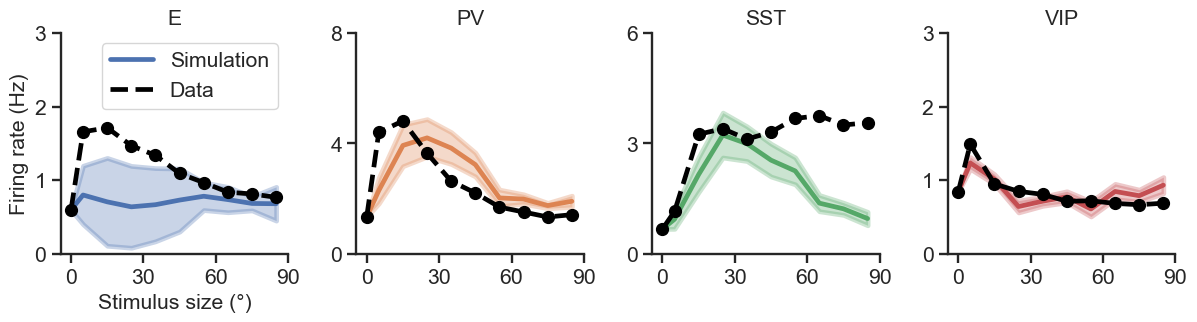

In [8]:
l_config =  ['final_gaussian_classical_without_residual_inputs']
l_title = [' without residual inputs']

l_celltype = ['E', 'PV', 'SST', 'VIP']
l_baseline = sio.loadmat("data/baselines.mat")['baseline']

size_tuning_data_classical = np.zeros((4, 10)) * np.nan
size_tuning_data_classical[:, 0] = l_baseline[0, :4]
size_tuning_data_classical[:, 1:] = rate_field_data[:, :9, 120]
l_stimulus = [5, 15, 25, 35, 45, 55, 65, 75, 85]
n_stimulus = len(l_stimulus)

l_stimulus_plot = [0, 5, 15, 25, 35, 45, 55, 65, 75, 85]
l_stim_type = [0]

for config_idx in range(len(l_config)):
    config = l_config[config_idx]

    folder_path = 'models/optimized_files_' + config
    model_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f != '.DS_Store']
    sorted_files = sorted(model_names, key=lambda name: float(name.replace('.pt', '')))
    sorted_numbers = sorted([float(f.replace('.pt', '')) for f in sorted_files])
    n_selected_models = len(sorted_files)
        
    size_tuning_data_classical_sim = np.zeros((n_selected_models, 4, 10)) * np.nan
    size_tuning_data_classical_sim[:, 0, 0] = l_baseline[0, 0]
    size_tuning_data_classical_sim[:, 1, 0] = l_baseline[0, 1]
    size_tuning_data_classical_sim[:, 2, 0] = l_baseline[0, 2]
    size_tuning_data_classical_sim[:, 3, 0] = l_baseline[0, 3]
    
    for model_name_idx in range(n_selected_models):
        model_name = sorted_files[model_name_idx]
        
        df = pd.read_csv('simulated_rate_fields/' + config + '_response_grid_' +  str(model_name) + '.csv')
        
        for i in l_stim_type:

            for j in range(4):
                
                for k in range(n_stimulus):
                    
                    if j == 0:
                        rate_field_sim_data = df[(df['cell_type'] == 'PYR') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                    elif j == 1:
                        rate_field_sim_data = df[(df['cell_type'] == 'PV') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                    elif j == 2:
                        rate_field_sim_data = df[(df['cell_type'] == 'SST') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values
                    else:
                        rate_field_sim_data = df[(df['cell_type'] == 'VIP') & (df['size'] == l_stimulus[k]) & (df['inverse'] == (i!=0))]['dr'].values

                    size_tuning_data_classical_sim[model_name_idx, j, k+1] = rate_field_sim_data[0] + l_baseline[0, j]

    fig, axes = plt.subplots(1, 4, figsize=(12, 2.9005))
    fig.tight_layout()


    for j in range(4):
        idx = j

        axes[idx].spines['top'].set_visible(False)
        axes[idx].spines['right'].set_visible(False)
        axes[idx].spines['bottom'].set_visible(True)
        axes[idx].spines['left'].set_visible(True)
        for axis in ['top', 'bottom', 'left', 'right']:
            axes[idx].spines[axis].set_linewidth(line_width)
        axes[idx].tick_params(width=line_width, length=tick_len)

        size_tuning_std = np.std(size_tuning_data_classical_sim[:, j, :], axis=0)
        if config == 'final_gaussian_classical_without_recurrent_connections':
            axes[idx].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linestyle='dashed', linewidth=plot_line_width, zorder=1)
        elif config == 'final_gaussian_classical_without_recurrent_excitatory_connections':
            axes[idx].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linestyle='dotted', linewidth=plot_line_width, zorder=1)
        else:
            axes[idx].plot(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0), color=pal[j], linewidth=plot_line_width, zorder=1)

        axes[idx].plot(l_stimulus_plot, size_tuning_data_classical[j, :], color='black', linestyle='dashed', linewidth=plot_line_width, zorder=2)
        axes[idx].fill_between(l_stimulus_plot, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0) - size_tuning_std, np.mean(size_tuning_data_classical_sim[:, j, :], axis=0) + size_tuning_std, linewidth=plot_line_width, color=pal[j], alpha=0.3)
        for n in range(10):
            axes[idx].plot(l_stimulus_plot[n], size_tuning_data_classical[j, n], marker='o', color='black', markersize=marker_size, zorder=2)

        axes[idx].set_title(l_celltype[j], fontdict = {'fontname': 'Arial', 'fontsize': font_size_1})
        axes[idx].set_xticks([0, 30, 60, 90])

        if j == 0:
            axes[idx].set_yticks([0, 1, 2, 3])
            axes[idx].set_ylim(0, 3)
        elif j == 1:
            axes[idx].set_yticks([0, 4, 8])
            axes[idx].set_ylim(0, 8)
        elif j == 2:
            axes[idx].set_yticks([0, 3, 6])
            axes[idx].set_ylim(0, 6)
        else:
            axes[idx].set_yticks([0, 1, 2, 3])
            axes[idx].set_ylim(0, 3)

        if idx == 0:
            axes[idx].legend(['Simulation', 'Data'], loc='upper right', prop={"family": "Arial", 'size': font_size_1})
            axes[idx].set_xlabel(f'Stimulus size (°)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})
            axes[idx].set_ylabel('Firing rate (Hz)', fontdict={'fontname': 'Arial', 'fontsize': font_size_1})

        axes[idx].tick_params(axis='both', which='major', labelsize=font_size_1)  # Customize tick label font size
        for label in (axes[idx].get_xticklabels() + axes[idx].get_yticklabels()):
            label.set_fontname('Arial')

    fig.subplots_adjust(hspace=0.4, wspace=0.3)
    # fig.savefig('paper_figures/paper_pdf/Fig_size_tuning_curves_manipulation_without_residual_inputs.pdf', bbox_inches='tight')